In [38]:
import numpy as np
import pandas as pd
from radioReduction import *
import matplotlib.pyplot as plt
from scipy.stats import norm
import scipy.optimize as op
import random
import emcee
import corner
from astropy.stats import LombScargle


In [39]:
'''
Importing the data and binning every 10 seconds
'''
dt = pd.read_table('1314/2M1314e19-LLRR.dat')
binned = binning(dt,sec=10,binning=2)

def binPlot(Type='minutes'):
    if Type == 'minutes':
        plt.errorbar(binned['dtmin'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['dtmin'],binned['re'],color='black',label='Data')
    else:
        plt.errorbar(binned['secs'],binned['re'],yerr=binned['ure'],linestyle='None',color='k',label='_nolegend_')
        plt.scatter(binned['secs'],binned['re'],color='black',label='Data') 

In [40]:
'''
Defining our model, likelihoood, and prior functions
'''
def linearModel(theta,x):
    '''
    Linear model fitting to the data
    '''
    m,b = theta
    y = m*x+b
    return y

def lnprior(theta):
    '''
    Uniform priors for m and b constrained by the data
    '''
    m,b = theta
    if -1 < m < .5 and 1.6 < b < 2.2:
        return 0.0
    return -np.inf

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-linearModel(theta,x))**2/yerr**2))

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [41]:
# Putting data to variables
x = binned['dtmin']
y = binned['re']
yerr = binned['ure']

In [42]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
nll = lambda *args: -lnlike(*args)
x0 = [5,3]
linearResult = op.minimize(nll,x0,args=(x,y,yerr))
m_ml,b_ml = linearResult.x
print(m_ml,b_ml)


-0.029667824877650056 1.9440762705301373


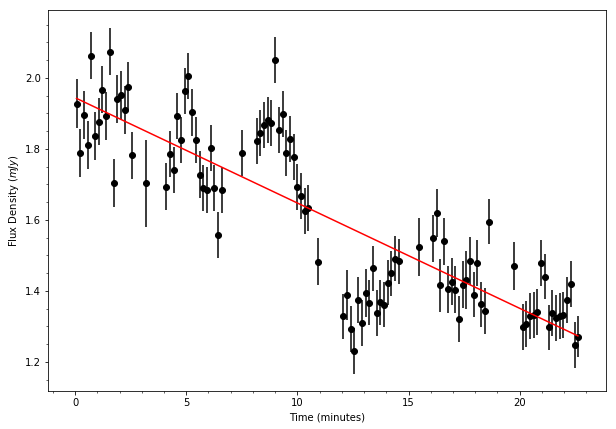

In [43]:
# Plotting results from maximized likelihood
plt.figure(figsize=(10,7))
binPlot(Type='minutes')
plt.plot(x,linearModel([m_ml,b_ml],x),color='red',label='Linear Model')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e19_linearModel.png')
plt.show()

In [44]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 2,100

# Initial position somewhere close to the maximum likelihood result
p0 = [linearResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
linearSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = linearSampler.run_mcmc(p0,500)
linearSampler.reset()

# Running MCMC
linearSampler.run_mcmc(pos,5000)

(array([[-0.03072035,  1.96453639],
        [-0.02855281,  1.93373683],
        [-0.03014458,  1.94943381],
        [-0.02892677,  1.94284835],
        [-0.03090582,  1.97530227],
        [-0.02793912,  1.92252279],
        [-0.03136372,  1.95925206],
        [-0.03033004,  1.95464824],
        [-0.02780954,  1.92270065],
        [-0.02903852,  1.93742258],
        [-0.02793599,  1.92096625],
        [-0.03009287,  1.95132964],
        [-0.02913461,  1.9432575 ],
        [-0.03098606,  1.96437574],
        [-0.03088376,  1.96390099],
        [-0.03003825,  1.93553732],
        [-0.02823346,  1.92603064],
        [-0.02996671,  1.95130692],
        [-0.02932184,  1.93493337],
        [-0.0293731 ,  1.94074803],
        [-0.02909554,  1.9312991 ],
        [-0.03102034,  1.96306298],
        [-0.03137511,  1.96776488],
        [-0.03162692,  1.96314007],
        [-0.02951858,  1.93107827],
        [-0.02810393,  1.92289258],
        [-0.02866075,  1.9397868 ],
        [-0.03019381,  1.954

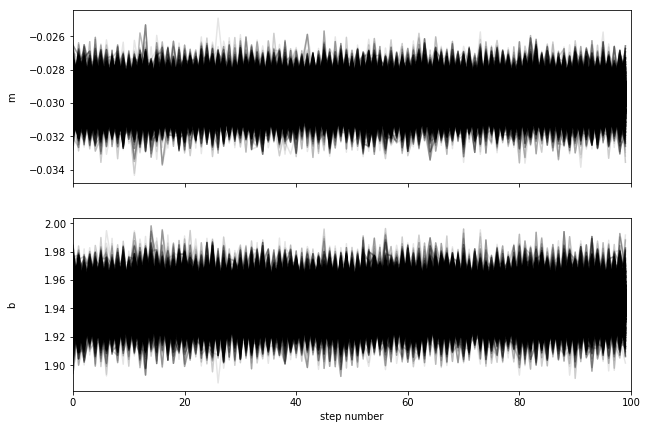

In [45]:
# Plotting the chains
fig, axes = plt.subplots(2,figsize=(10,7),sharex=True)
linearSamples = linearSampler.chain
labels = ['m','b']
for i in range(ndim):
    ax = axes[i]
    ax.plot(linearSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(linearSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('plots/1314e19_linearTrace.png')
plt.show()

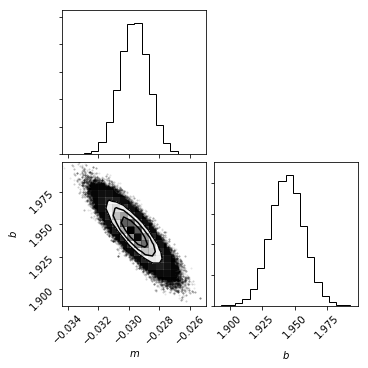

In [46]:
# Flattening the sampler
linearFlat = linearSampler.chain[:,:,:].reshape((-1,ndim))

fig = corner.corner(linearFlat,labels=['$m$','$b$'])
plt.savefig('plots/1314e19_linearCorner.png')
plt.show()

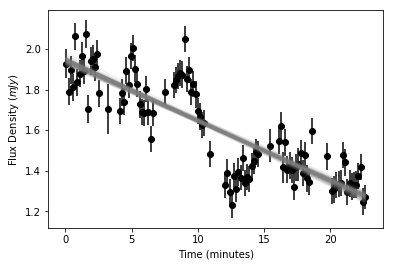

In [47]:
# Plotting first few MCMC steps on the data
binPlot(Type='minutes')
for m,b in linearFlat[np.random.randint(len(linearFlat),size=100)]:
    plt.plot(binned['dtmin'],m*binned['dtmin']+b,color='gray',alpha=0.1)
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/1314e19_500mcmc_data.png')
plt.show()

In [48]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(ndim):
    mcmc = np.percentile(linearFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.3f}_{{-{1:.3f}}}^{{{2:.3f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

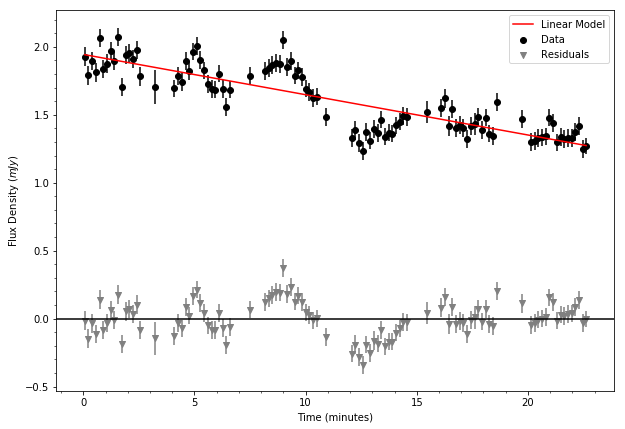

In [49]:
# Getting the 50th percentile of each parameter
linearParameters = []

for i in range(ndim):
    linearParameters.append(np.percentile(linearFlat[:,i],50))
linearParameters = np.array(linearParameters)

# Making model line
linear_model = linearModel(linearParameters,x)

# Residuals
linear_resid = y - linear_model

# Plotting the 50th percentile against the data along with residuals
plt.figure(figsize=(10,7))
plt.scatter(x,y,color='k',marker='o',label='Data')
plt.errorbar(x,y,yerr=yerr,color='black',linestyle='None',label='_nolegend_')
plt.plot(x,linear_model,color='red',label='Linear Model')
plt.scatter(x,linear_resid,color='gray',marker='v',label='Residuals')
plt.errorbar(x,linear_resid,yerr=yerr,color='gray',linestyle='None',label='_nolegend_')
plt.axhline(y=0,color='black')
plt.legend(loc='best')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.minorticks_on()
plt.savefig('plots/1314e19_linearModel_fit.png')
plt.show()

In [50]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-linearModel(theta,x))/yerr))
chiSquare(linearParameters,y,yerr)/(len(x)-2)

3.8256674562186905

## Fitting an logistic function


In [51]:
def logModel(theta,x):
    '''
    Logistic model w/ added term y0 to translate it up
    '''
    l,k,x0,y0 = theta
    denom = 1+np.exp(-k*(x-x0))
    return y0+l/denom

def lnlike(theta,x,y,yerr):
    '''
    Log of the likelihood function (chi^2)
    '''
    return -0.5*(np.sum((y-logModel(theta,x))**2/yerr**2))

def lnprior(theta):
    '''
    Uniform priors for a and b constrained by the data
    '''
    l,k,x0,y0 = theta
    if -2.5 < l < 0 and -5 < k < 10 and 9 < x0 < 15 and 1.6 < y0 < 2.0:
        return 0.0
    return -np.inf

def lnprob(theta,x,y,err):
    '''
    Putting prior and likelihood together
    '''
    lnp = lnprior(theta)
    if not np.isfinite(lnp):
        return -np.inf
    return lnp + lnlike(theta,x,y,yerr)

In [52]:
# Optimizing the lnlikelihood
# Minimize to -log of the likelihood to maximize the likelihood
x = binned['dtmin']
nll = lambda *args: -lnlike(*args)
p0 = [2,6,10,1]
logResult = op.minimize(nll,p0,args=(x,y,yerr))
l_ml,k_ml,x0_ml,y0_ml = logResult.x

print(l_ml,k_ml,x0_ml,y0_ml)

-0.4528223066730901 3.1683989202336402 10.39846579331271 1.8441010944872955


In [53]:
'''
Running MCMC
'''
# 2 parameters, 100 walkers
ndim,nwalkers = 4,100

# Initial position somewhere close to the maximum likelihood result
p0 = [logResult['x']+1e-4*np.random.randn(ndim) for i in range(nwalkers)]

# Setting up the sampler
logSampler = emcee.EnsembleSampler(nwalkers,ndim,lnprob,args=(x,y,yerr))

# Running a burn in of 100 steps
pos, prob, state = logSampler.run_mcmc(p0,500)
logSampler.reset()

# Running MCMC
logSampler.run_mcmc(pos,5000)

(array([[-0.46030429,  5.39310965, 10.34396287,  1.86148437],
        [-0.46426538,  3.45072007, 10.46520454,  1.85095076],
        [-0.46849883,  3.18642492, 10.50420716,  1.83701412],
        [-0.44585889,  2.96129741, 10.42581257,  1.83178274],
        [-0.45607286,  3.96585517, 10.48754978,  1.83945686],
        [-0.45086978,  3.25793799, 10.31174274,  1.84255109],
        [-0.44614745,  2.96276974, 10.4865233 ,  1.84087898],
        [-0.46616219,  5.35662125, 10.20442582,  1.83620806],
        [-0.43050699,  3.28869887, 10.33167906,  1.83895357],
        [-0.45688917,  2.89071136, 10.39808311,  1.84501476],
        [-0.45560639,  2.49617596, 10.32070055,  1.84387898],
        [-0.46233785,  3.48317978, 10.29239757,  1.8530255 ],
        [-0.45723177,  3.67666908, 10.18168843,  1.84845461],
        [-0.45675349,  3.6376883 , 10.37817352,  1.84321649],
        [-0.4696834 ,  3.63787472, 10.56605575,  1.86805679],
        [-0.45210479,  3.54955136, 10.35914258,  1.84337059],
        

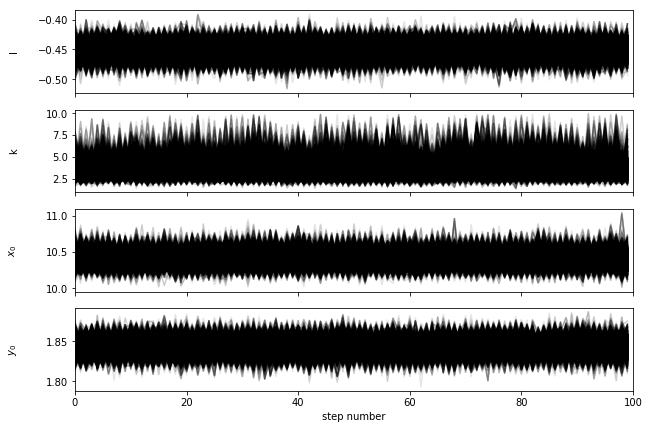

In [54]:
# Plotting the chains
fig, axes = plt.subplots(4,figsize=(10,7),sharex=True)
logSamples = logSampler.chain
labels = ['l','k','$x_0$','$y_0$']
for i in range(4):
    ax = axes[i]
    ax.plot(logSamples[:,:,i],"k",alpha=0.1)
    ax.set_xlim(0,len(logSamples))
    ax.set_ylabel(labels[i])
    ax.yaxis.set_label_coords(-0.1,0.5)
axes[-1].set_xlabel('step number')
plt.savefig('plots/1314e19_Trace.png')
plt.show()

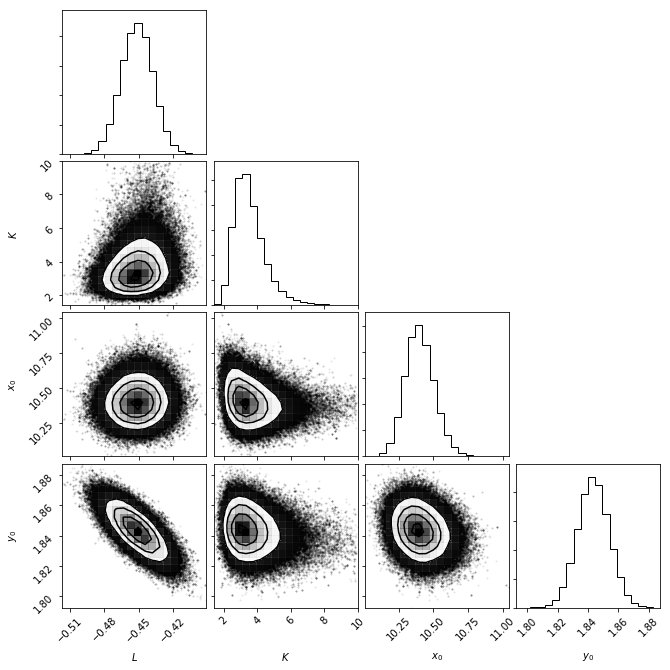

In [55]:
# Flattening the sampler
logFlat = logSampler.chain[:,:,:].reshape((-1,4))
fig = corner.corner(logFlat,labels=['$L$','$K$','$x_0$','$y_0$'])
plt.savefig('plots/1314e19_logCorner.png')
plt.show()

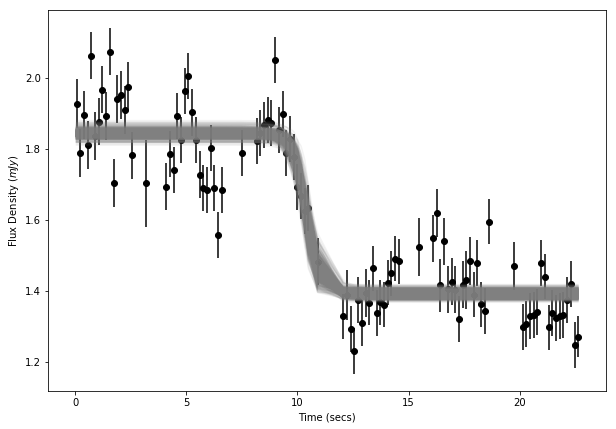

In [56]:
# Plotting first few MCMC steps on the data
plt.figure(figsize=(10,7))
binPlot(Type='minutes')
for l,k,x0,y0 in logFlat[np.random.randint(len(logFlat),size=500)]:
    plt.plot(x,logModel([l,k,x0,y0],x),color='gray',alpha=0.1)
plt.xlabel('Time (secs)')
plt.ylabel('Flux Density ($mJy$)')
plt.savefig('plots/1314e19_500mcmc_log.png')
plt.show()

In [57]:
# Calculating the uncertainties based off of 16th,50th, and 84th percentile
from IPython.display import display, Math

for i in range(4):
    mcmc = np.percentile(logFlat[:,i],[16,50,84])
    q = np.diff(mcmc)
    txt = "\mathrm{{{3}}} = {0:.5f}_{{-{1:.5f}}}^{{{2:.5f}}}"
    txt = txt.format(mcmc[1],q[0],q[1],labels[i])
    display(Math(txt))

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

<IPython.core.display.Math object>

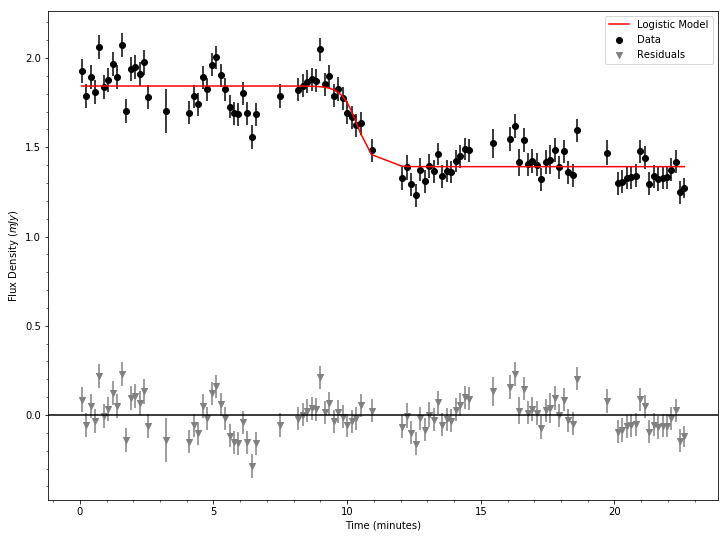

In [58]:
# Getting the 50th percentile of each parameter
logParameters = []

for i in range(4):
    logParameters.append(np.percentile(logFlat[:,i],50))
logParameters = np.array(logParameters)

# Making logistic model
log_model = logModel(logParameters,x)

# Calculating residuals
logResid = y - log_model

# Plotting against the data
plt.figure(figsize=(12,9))
binPlot(Type='minutes')
plt.plot(x,log_model,color='red',label='Logistic Model')
plt.scatter(x,logResid,color='gray',marker='v',label='Residuals')
plt.errorbar(x,logResid,yerr=yerr,color='gray',label='_nolegend_',linestyle='None')
plt.axhline(y=0,color='black')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.minorticks_on()
plt.savefig('plots/1314e19_logModel.png')
plt.show()

In [59]:
# calculating chi_square
def chiSquare(theta,y,yerr):
    return np.sum(np.square((y-logModel(theta,x))/yerr))
chiSquare(logParameters,y,yerr)/(len(x)-4)

2.2196178205747437

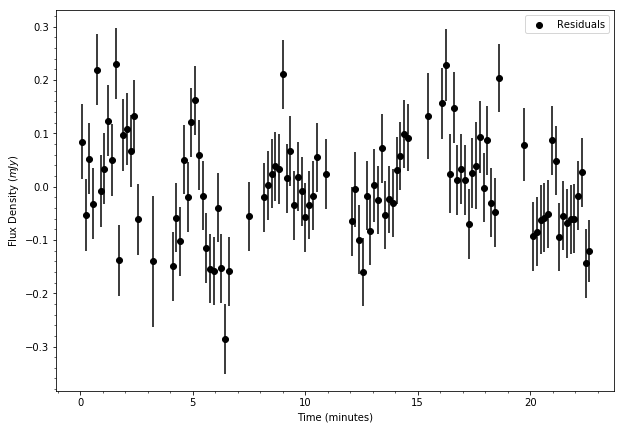

In [60]:
plt.figure(figsize=(10,7))
plt.scatter(x,logResid,color='black',marker='o',label='Residuals')
plt.errorbar(x,logResid,yerr=yerr,color='black',label='_nolegend_',linestyle='None')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.minorticks_on()
plt.show()

## e19 Looking at Stokes I, V and circular polarization

In [74]:
rr = pd.read_table('1314/2M1314e19-RR.dat')
ll = pd.read_table('1314/2M1314e19-LL.dat')

rr = binning(rr,10,2)
ll = binning(ll,10,2)

In [75]:
stI = (rr['re']+ll['re'])*.5
stV = (rr['re']-ll['re'])*.5
frac = stV/stI
stErr = np.sqrt(rr['ure']**2+ll['ure']**2)*.5
time = rr['dtmin']

In [76]:
data = pd.DataFrame(data={'time':time,'stI':stI,'stErr':stErr})
data.to_csv('stokesI.csv')

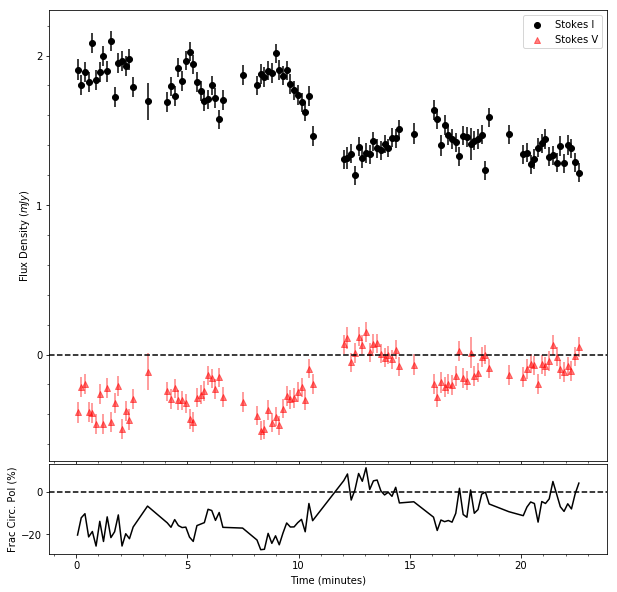

In [77]:
fig,ax = plt.subplots(figsize=(10,10),nrows=2,ncols=1,sharex=True,gridspec_kw = {'hspace':0.01,'height_ratios':[5,1]})
ax[0].scatter(time,stI,color='black',marker='o',label='Stokes I')
ax[0].errorbar(time,stI,yerr=stErr,color='k',linestyle='None',label='_nolegend_')
ax[0].scatter(time,stV,color='red',marker='^',label='Stokes V',alpha=0.5)
ax[0].errorbar(time,stV,yerr=stErr,color='red',linestyle='None',label='_nolegend_',alpha=0.5)
ax[0].axhline(y=0,color='k',linestyle='dashed')
ax[0].legend(loc='best')
ax[0].set_ylabel('Flux Density ($mJy$)')
ax[0].locator_params(axis='y',nbins=4)
ax[0].minorticks_on()

ax[1].plot(time,100*frac,color='k')
ax[1].axhline(y=0,color='k',linestyle='--')
ax[1].set_ylabel('Frac Circ. Pol (%)')

plt.xlabel('Time (minutes)')
plt.savefig('plots/1314e19_stokes.png')
plt.show()

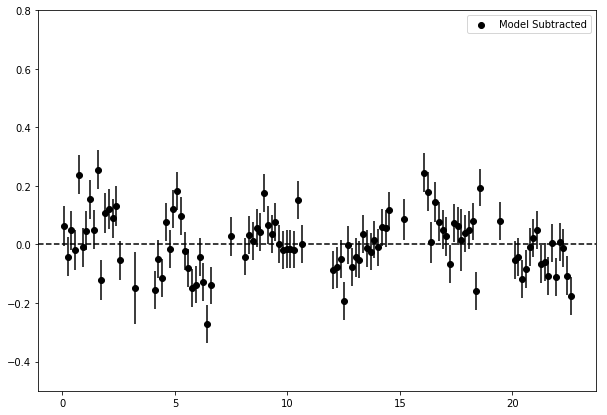

In [78]:
modelSub = stI - log_model

plt.figure(figsize=(10,7))
plt.scatter(time,modelSub,color='k',marker='o',label='Model Subtracted')
plt.errorbar(time,modelSub,yerr=stErr,color='k',linestyle='None',label='_nolegend_')
plt.axhline(y=0,color='k',linestyle='dashed')
plt.ylim(-0.5,0.8)
plt.legend(loc='best')
plt.show()

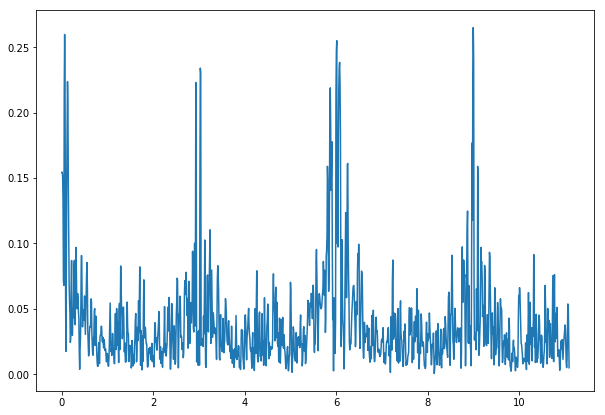

           freq     power         time
1013   8.995562  0.265090     6.669956
7      0.066568  0.259813   901.333333
677    6.013314  0.255053     9.977860
676    6.004438  0.247204     9.992609
1014   9.004438  0.243472     6.663381
684    6.075444  0.238504     9.875822
341    3.031065  0.234079    19.795022
683    6.066568  0.234045     9.890271
342    3.039941  0.230799    19.737226
1012   8.986686  0.228719     6.676543
14     0.128698  0.223737   466.206897
330    2.933432  0.223098    20.453858
685    6.084320  0.223002     9.861415
661    5.871302  0.218982    10.219199
682    6.057692  0.218758     9.904762
6      0.057692  0.216214  1040.000000
8      0.075444  0.215683   795.294118
675    5.995562  0.212853    10.007402
15     0.137574  0.207374   436.129032
660    5.862426  0.200247    10.234671
662    5.880178  0.190629    10.203774
13     0.119822  0.186443   500.740741
686    6.093195  0.185494     9.847050
681    6.048817  0.179972     9.919296
665    5.906805  0.177804

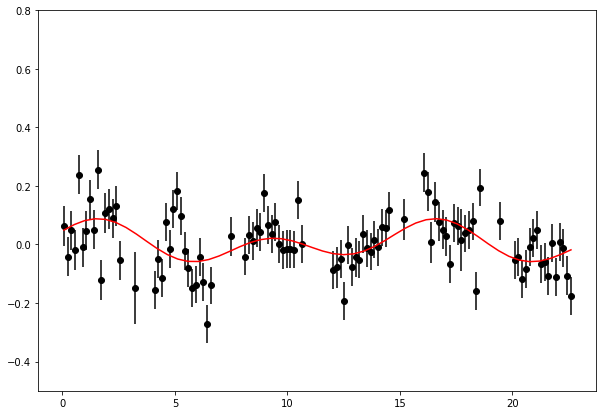

15.022222224622963


In [79]:
freq, power = LombScargle(time,modelSub,stErr,nterms=2).autopower()
plt.figure(figsize=(10,7))
plt.plot(freq,power)
plt.show()

lomb = pd.DataFrame(data={'freq':freq,'power':power,'time':1/freq*60})
lomb = lomb.sort_values('power',ascending=False)
print(lomb)

best_freq = lomb['freq'].iloc[1]
x_fit = np.linspace(np.min(time),np.max(time))
y_fit = LombScargle(time,modelSub,stErr,nterms=2).model(x_fit,best_freq)

plt.figure(figsize=(10,7))
plt.scatter(time,modelSub,color='black')
plt.errorbar(time,modelSub,color='black',yerr=stErr,linestyle='None')
plt.plot(x_fit,y_fit,color='red')
plt.ylim(-0.5,0.8)
plt.show()
print(1/best_freq)

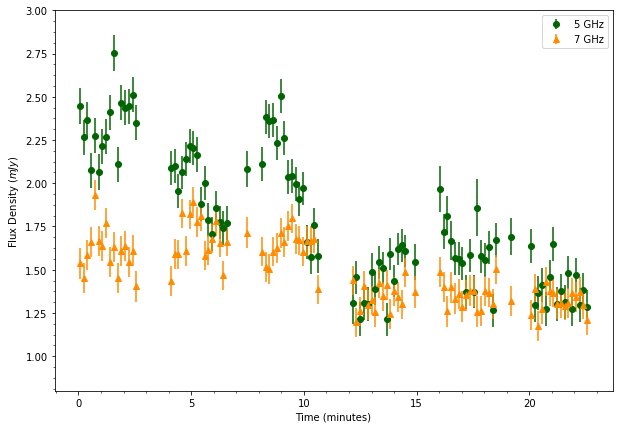

In [70]:
plt.figure(figsize=(10,7))
plt.errorbar(low['dtmin'],low['re'],yerr=low['ure'],marker='o',color='darkgreen',linestyle='None',label='5 GHz')
plt.errorbar(high['dtmin'],high['re'],yerr=high['ure'],marker='^',color='darkorange',linestyle='None',label='7 GHz')
plt.xlabel('Time (minutes)')
plt.ylabel('Flux Density ($mJy$)')
plt.legend(loc='best')
plt.ylim(0.8,3)
plt.minorticks_on()
plt.show()

In [71]:
low['re'].mean()

1.802068751273253